# 스타일 전이 학습

### 1. 이미지 로드 및 전처리

In [1]:
import requests
from PIL import Image
from io import BytesIO
import torchvision.transforms as transforms

# 함수 정의: 이미지 로드 + Transform
def load_image(img_url, max_size=400):
  response = requests.get(img_url)
  image = Image.open(BytesIO(response.content)).convert("RGB")
  size = max(image.size) if max(image.size) < max_size else max_size
  transform = transforms.Compose([
      transforms.Resize((size, size)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ])
  return transform(image).unsqueeze(0)

In [2]:
# 함수 정의: Tensor -> 이미지 변환
def img_convert(tensor):
  image = tensor.to("cpu").clone().detach().squeeze()
  image = image.numpy().transpose(1, 2, 0)
  image = image * [0.229, 0.224, 0.225]
  image = image + [0.485, 0.456, 0.406]
  return image.clip(0, 1)

In [3]:
# 이미지 url
content_url = "https://pytorch.org/tutorials/_static/img/neural-style/dancing.jpg"
style_url = "https://pytorch.org/tutorials/_static/img/neural-style/picasso.jpg"

In [4]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 이미지 로드
content = load_image(content_url).to(device)
style = load_image(style_url).to(device)

### 2. 모델 로드

In [5]:
import torchvision.models as models

# 모델 로드 (특징 추출 레이어)
vgg = models.vgg19(pretrained=True).features.to(device).eval()

for param in vgg.parameters():
  param.requires_grad_(False)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [00:05<00:00, 113MB/s]


### 3. 학습 준비

In [6]:
# 함수 정의: 특정 레이어를 통과한 feature를 반환
def get_features(image, model):
  layers = {
      "0": "conv1_1",
      "5": "conv2_1",
      "10": "conv3_1",
      "19": "conv4_1",
      "21": "conv4_2",
      "28": "conv5_1",
  }
  features = {}

  x = image
  for name, layer in model._modules.items():
    x = layer(x)
    if name in layers:
      features[layers[name]] = x

  return features

In [7]:
# 함수 정의: 스타일 표현에 대한 행렬 반환
def gram_matrix(tensor):
  b, c, h, w = tensor.size()
  tensor = tensor.view(c, h * w)
  return torch.mm(tensor, tensor.t())

In [8]:
# feature 추출
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)
style_grams = {
    feature: gram_matrix(style_features[feature]) for feature in style_features
}

# 학습 준비
target = content.clone().requires_grad_(True)
optim = torch.optim.Adam([target], lr=0.003)
style_weight = 1e6
content_weight = 1

### 4. 스타일 전이 학습

In [9]:
for i in range(200):
  # 결과 정의
  target_features = get_features(target, vgg)

  # 콘텐츠 손실 계산
  content_loss = torch.mean((target_features["conv4_2"] - content_features["conv4_2"]) ** 2)

  # 스타일 손실 계산
  style_loss = 0
  for i in style_grams:
    target_gram = gram_matrix(target_features[i])
    style_gram = style_grams[i]
    layer_loss = torch.mean((target_gram - style_gram) ** 2)
    style_loss += layer_loss / (target_features[i].shape[1] ** 2)

  total_loss = content_weight * content_loss + style_weight * style_loss  # 총손실 계산
  optim.zero_grad()
  total_loss.backward()
  optim.step()

### 5. 결과 시각화

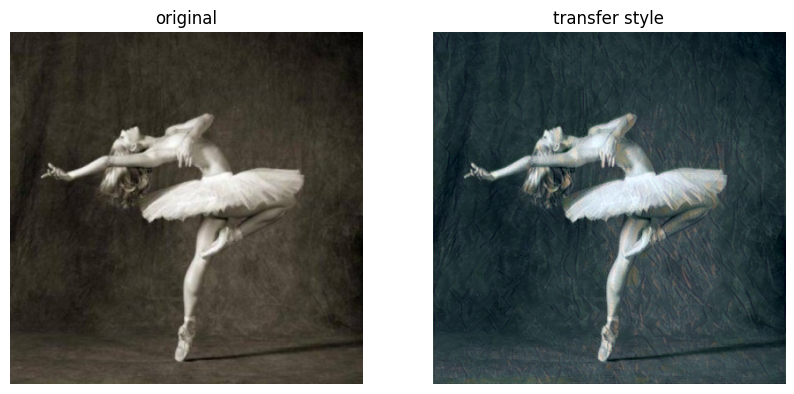

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img_convert(content))
plt.title("original")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(img_convert(target))
plt.title("transfer style")
plt.axis("off")
plt.show()

### [실습] 스타일 전이 학습

- 스타일 이미지 1장 + 콘텐츠 이미지 3장